<a href="https://colab.research.google.com/github/becksons/LyricClassificationMLProject/blob/main/LyricClassifierProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline
#hello
# Load pre-trained model and tokenizer
model_name = "bert-base-uncased"
model = BertForSequenceClassification.from_pretrained(model_name)

tokenizer = BertTokenizer.from_pretrained(model_name)



KeyboardInterrupt: ignored

In [ ]:
from transformers import pipeline
# classifier = pipeline("text-classification",model='bhadresh-savani/albert-base-v2-emotion', return_all_scores=True)
classifier = pipeline("sentiment-analysis",model="j-hartmann/emotion-english-distilroberta-base", return_all_scores=True,device = 0)

classifier("I am very sad")

config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/294 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


[[{'label': 'anger', 'score': 0.0005999401910230517},
  {'label': 'disgust', 'score': 0.0011589934583753347},
  {'label': 'fear', 'score': 0.0009129178361035883},
  {'label': 'joy', 'score': 0.0016049192054197192},
  {'label': 'neutral', 'score': 0.004203449469059706},
  {'label': 'sadness', 'score': 0.9875375628471375},
  {'label': 'surprise', 'score': 0.003982181195169687}]]

In [ ]:

def get_top_2sents(sentence):
    results = classifier(sentence)
    # 'results'-> list of lists. Each inner list contains dictionaries for each sentiment label and score.
    # We need to process the first element of this list (results[0])
    top_2_sents = sorted(results[0], key=lambda x: x['score'], reverse=True)[:2]
    return [(r['label'], r['score']) for r in top_2_sents]

# Testing the function
s = get_top_2sents("I am not mad, just disappointed")
print("Sentence: I am not mad, just disappointed")
print(s)


Sentence: I am not mad, just disappointed
[('sadness', 0.6130071878433228), ('anger', 0.2586817443370819)]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import torch

if torch.cuda.is_available():
    device = 0  # Device ID (typically 0 for a single-GPU setup)
    print("CUDA is available. Using GPU:", torch.cuda.get_device_name(device))
else:
    device = -1  #defaults to CPU
    print("CUDA not available, using CPU")


Mounted at /content/drive
CUDA is available. Using GPU: Tesla V100-SXM2-16GB


In [ ]:
import os

folder_path = '/content/drive/MyDrive/Lyric_Dataset/lyrics'


concatenated_text = ""

for filename in os.listdir(folder_path)[:10]:

    if filename.endswith('.txt'):
        file_path = os.path.join(folder_path, filename)


        with open(file_path, 'r') as file:
            file_content = file.read()


            concatenated_text += file_content + "\n"



text_lines = concatenated_text.split('\n')
print(len(text_lines))
labels = []

label =  classifier(text_lines[3])
print(label[0]['label'])
for line in text_lines[100]:
    category = classifier(line)
    labels.append(category[0]['label'])



31297


TypeError: ignored

In [ ]:
input_data = []
for i in range(len(labels)):
  input_data.append((text_lines[i],labels[i]))
for i in range(20):

  print(input_data[i])
anger = 0
surprise = 0
love = 0
sadness = 0
joy = 0
fear = 0

for text, label in input_data:
    if(label == 'anger'):
        anger+=1
    if(label == 'surprise'):
        surprise+=1
    if(label == 'love'):
        love+=1
    if(label == 'sadness'):
        sadness+=1
    if(label == 'joy'):
        joy+=1
    if(label == 'fear'):
        fear+=1
print("\nAnger: ", anger,"Surprise: ", surprise,"Love: ", love,"Sadness: ", sadness," Joy: ",joy, "Fear: ", fear)

In [ ]:
from collections import defaultdict
import random
samples_per_label = defaultdict(list)

# Group samples by label
for text, label in input_data:
    samples_per_label[label].append((text, label))

# Find the minimum number of samples across all labels
min_samples =min(len(samples) for samples in samples_per_label.values())

# Sample an equal number of samples from each label
balanced_data = []
for label, samples in samples_per_label.items():
    balanced_data.extend(random.sample(samples, min_samples))

# Shuffle the balanced data
random.shuffle(balanced_data)

# Now, balanced_data contains an equal number of samples for each label
print(len(balanced_data))

In [ ]:
label_to_int = {
    'anger': 0,
    'surprise': 1,
    'love': 2,
    'sadness':3,
    'joy': 4,
    'fear': 5

}
input_data = [(text, label) for text, label in balanced_data]



In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


class LyricsDataset(Dataset):
    def __init__(self, lyrics, labels, tokenizer, max_len):
        self.lyrics = lyrics
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.lyrics)

    def __getitem__(self, item):
        text = str(self.lyrics[item])
        target = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'lyric_text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(target, dtype=torch.long)
        }

SyntaxError: ignored

# Sentiment Analysis based on Artists

In [ ]:
import os
import re
from google.colab import drive
drive.mount('/content/drive')
# artists_used_sample_vs_song = ['amy-winehouse','bob-marley','adele','eminem','michael-jackson','radiohead','drake','lil-wayne','kanye-west','nirvana','dickinson','pink-floyd']
artists_used = ['amy-winehouse','bob-marley','adele','eminem','disney','lady-gaga','drake','lil-wayne','dolly-parton','nirvana','dickinson','pink-floyd']
folder_path = '/content/drive/MyDrive/Lyric_Dataset/lyrics'

concatenated_text = ""
artist_lyrics = {}
for filename in os.listdir(folder_path):
    if filename.endswith('.txt'):
        file_path = os.path.join(folder_path, filename)
        with open(file_path, 'r') as file:
            file_content = file.read()

            concatenated_text += file_content + "\n"
            artist = re.sub(r'.txt', '', filename)

            if artist in artists_used:
              artist_lyrics[artist] = ' '.join(file_content.split(r'\.\.\.|\n')).split('\n')

text_lines = re.split(r'\.\.\.|\n', concatenated_text)


text_lines = [line.split(' ') for line in text_lines]

labels = []
for k in artist_lyrics:
  print(k)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
amy-winehouse
bob-marley
eminem
drake
lady-gaga
dolly-parton
lil-wayne
adele
nirvana
disney
dickinson
pink-floyd


**How would one go about classifying the general mood of an artist's lyrics? What would be the best way?**


For some test data, we have found text documents of many different artist lyrics, with each text file consisting of around 2000-5000 lines on average. All example artists used are stored in a dictionary with their name as the key and a list of their lyrics for the values.

Here are some questions that were brought up when experimenting with this data:

All the lyrics in each document are in order by song, and for each song, the next line is the next lyric in a song (except for between songs). Would it be a better idea to classify the lyrics of each song seperatley, and then average the score for top sentiment, or should we sample random lyrics of the artist to get the general sentiment?

We made a pros and cons list:

**Classifying Each Song Separately and Averaging the Sentiment**


Pros:
- Analyzing entire songs maintains the lyrical and emotional context. Sentiments often develop or change throughout a song, and considering the whole song can capture this progression.
- This method allows for song-specific analysis, which can be insightful for understanding the sentiment of particular pieces.
- Consistency Across Artists: If all artists' songs are treated similarly, comparisons across different artists become more meaningful.

Cons:

- Analyzing entire songs is more computationally intensive, especially for artists with lengthy songs.
- If some songs have stronger sentiments than others, they could disproportionately influence the average sentiment.(Biased)


**Sampling Random Lyrics:**

Pros:

-  This method is less computationally demanding and faster, as it involves processing fewer lines.
- It provides a broad, general overview of an artist's sentiment, which can be useful

Cons:

- Random lines might lose the emotional and narrative context, leading to potential misinterpretation of sentiments.
-  Random sampling might unintentionally favor certain songs or types of lyrics, especially if some songs have more emotionally charged or neutral lines than others.


**Finding Average Sentiment by "Song"**

Since the data for each artists we obtained does not separate the lyrics by song. After realizing this, we also realized that separating each text file into songs would be a a very long and tedious process. To try and find a solution, we asked ChatGPT how many lyric lines does the average song have. Of course, this varies heavily, but for the sake of our research, we chose 42 lines:

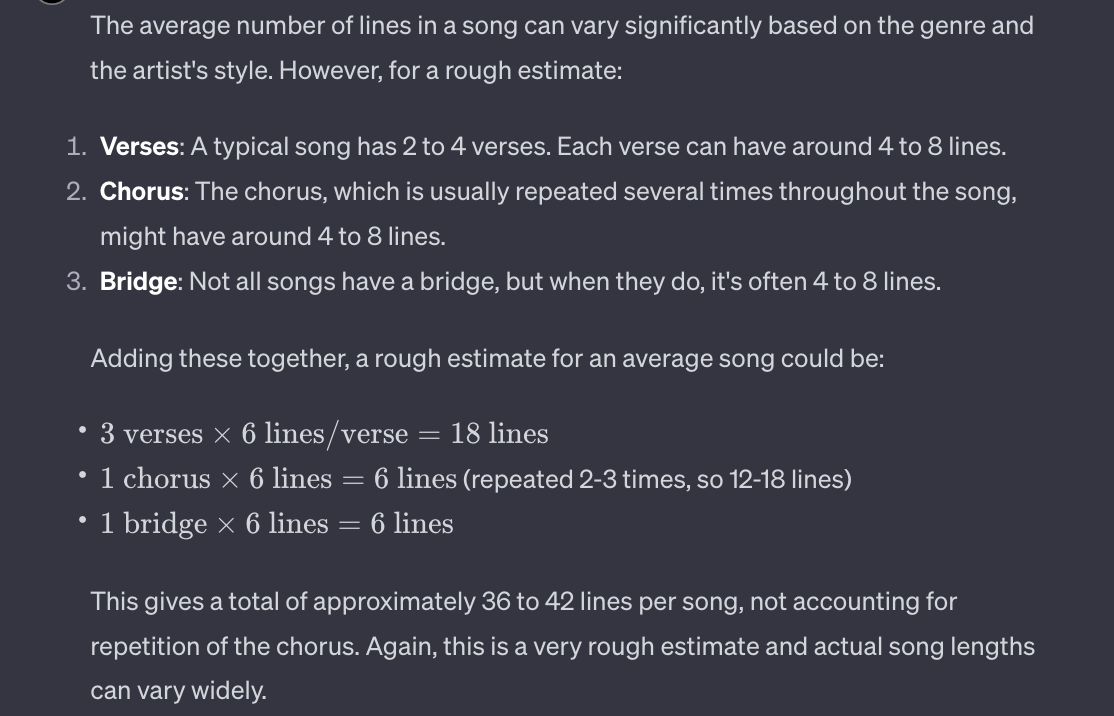


In [ ]:
import matplotlib.pyplot as plt
import torch
device = torch.device('cuda')

# Calculate the average sentiment for each batch of 42 lines for each artist
artist_avg_sentiments = {}
for artist, lyrics in artist_lyrics.items():
    batch_avg_scores = []
    emotion_counts = {}

    for i in range(0, len(lyrics), 42):
        batch_lyrics = lyrics[i:i+42]
        line_avg_scores = []

        for lyric in batch_lyrics:
            top_2 = get_top_2sents(lyric)

            filtered_top_2 = [sent for sent in top_2 if sent[0].lower() != 'neutral']

            if filtered_top_2:
                # Calculate the average score of the non-neutral top sentiments
                line_score = sum(score for _, score in filtered_top_2) / len(filtered_top_2)
                line_avg_scores.append(line_score)

                # Count the emotions (excluding 'neutral')
                for emotion, _ in filtered_top_2:
                    emotion_counts[emotion] = emotion_counts.get(emotion, 0) + 1

        # Calculate the average score for batch
        if line_avg_scores:
            batch_avg = sum(line_avg_scores) / len(line_avg_scores)
            batch_avg_scores.append(batch_avg)

        print(artist, i // 42, "/", len(lyrics) // 42)

    overall_avg = sum(batch_avg_scores) / len(batch_avg_scores) if batch_avg_scores else 0

    most_common_emotion = max(emotion_counts, key=emotion_counts.get, default="Unknown")

    artist_avg_sentiments[artist] = (overall_avg, most_common_emotion)


**Finding Average Sentiment of Arist by Sampling**


In [ ]:
import matplotlib.pyplot as plt
import torch
device = torch.device('cuda')
import random

artist_avg_sentiments_sample = {}
for artist, lyrics in artist_lyrics.items():
    # Select 1500 samples or all lyrics if there are less than 1500
    sample_size = min(1500, len(lyrics))
    sampled_lyrics = random.sample(lyrics, sample_size)

    line_avg_scores = []
    emotion_counts = {}
    count = 0

    for lyric in sampled_lyrics:
        top_2 = get_top_2sents(lyric)

        filtered_top_2 = [sent for sent in top_2 if sent[0].lower() != 'neutral']

        if filtered_top_2:
            line_score = sum(score for _, score in filtered_top_2) / len(filtered_top_2)
            line_avg_scores.append(line_score)

            for emotion, _ in filtered_top_2:
                emotion_counts[emotion] = emotion_counts.get(emotion, 0) + 1
                print(artist, count, "/", sample_size)
                count+=1

    artist_avg = sum(line_avg_scores) / len(line_avg_scores) if line_avg_scores else 0

    most_common_emotion = max(emotion_counts, key=emotion_counts.get, default="Unknown")

    artist_avg_sentiments_sample[artist] = (artist_avg, most_common_emotion)


NameError: ignored

**Results:**

Now that we have created 2 dictionaries that hold each artist's average sentiment value, one from sampling and one from grouping by 'song', we can plot and compare the results:

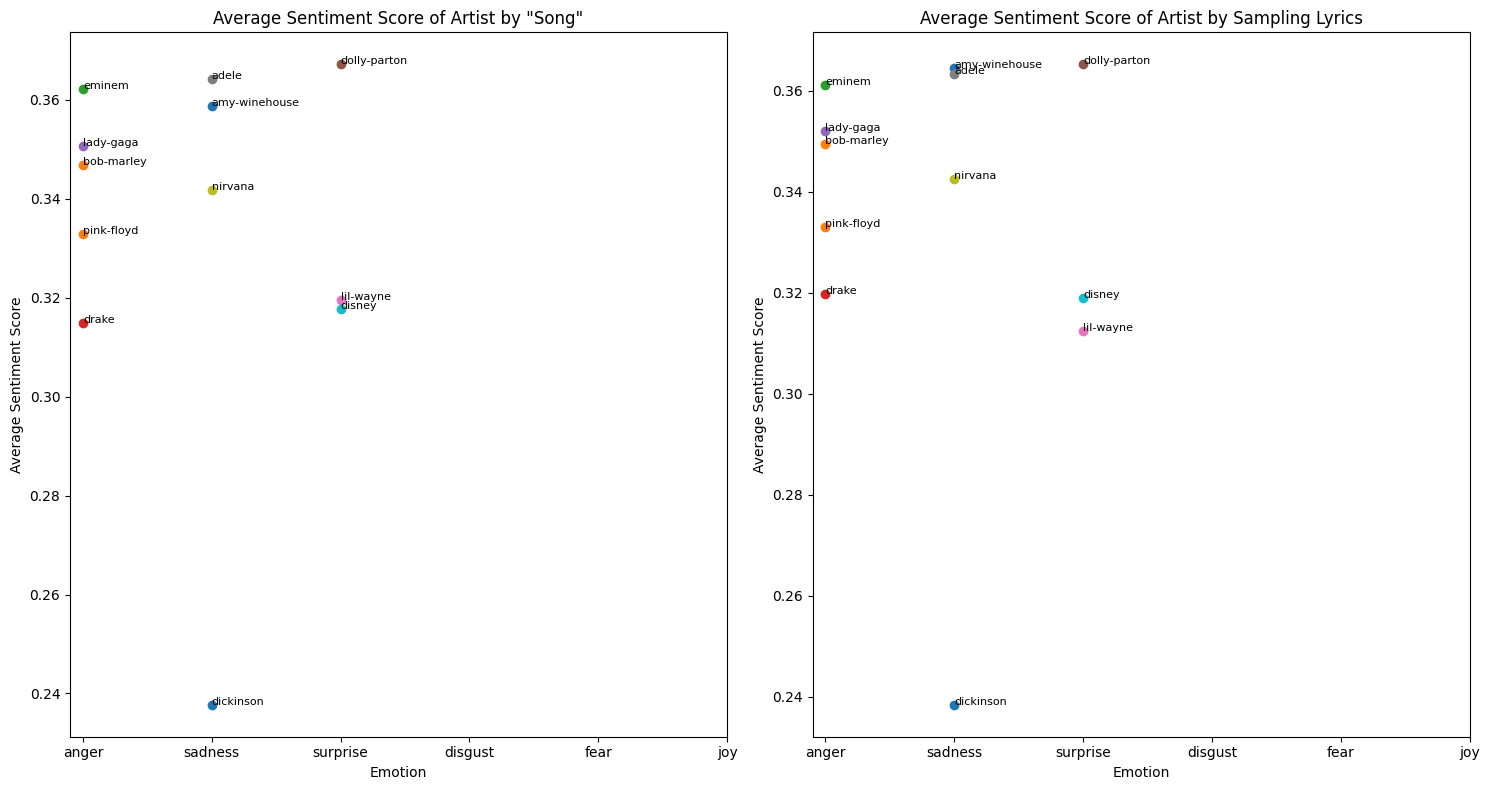

In [ ]:
import matplotlib.pyplot as plt


emotion_labels = ['anger', 'sadness', 'surprise', 'disgust', 'fear', 'joy']


x_coords1 = []
y_coords1 = []
artist_names1 = []
for artist, (avg_score, emotion) in artist_avg_sentiments.items():
    x_coords1.append(emotion_labels.index(emotion))
    y_coords1.append(avg_score)
    artist_names1.append(artist)

# for artist_avg_sentiments_sample
x_coords2 = []
y_coords2 = []
artist_names2 = []
for artist, (avg_score, emotion) in artist_avg_sentiments_sample.items():
    x_coords2.append(emotion_labels.index(emotion))
    y_coords2.append(avg_score)
    artist_names2.append(artist)


plt.figure(figsize=(15, 8))


plt.subplot(1, 2, 1)
for x, y, artist in zip(x_coords1, y_coords1, artist_names1):
    plt.scatter(x, y, label=artist)
    plt.text(x, y, artist, fontsize=8)
plt.xlabel('Emotion')
plt.ylabel('Average Sentiment Score')
plt.title('Average Sentiment Score of Artist by "Song"')
plt.xticks(range(len(emotion_labels)), emotion_labels)


plt.subplot(1, 2, 2)
for x, y, artist in zip(x_coords2, y_coords2, artist_names2):
    plt.scatter(x, y, label=artist)
    plt.text(x, y, artist, fontsize=8)
plt.xlabel('Emotion')
plt.ylabel('Average Sentiment Score')
plt.title('Average Sentiment Score of Artist by Sampling Lyrics')
plt.xticks(range(len(emotion_labels)), emotion_labels)


plt.tight_layout()
plt.show()


It is interesting how this group of artists are more on the sad/angry side. You wouldn't expect the lyrics of Bob Marley to be angry, or disney lyrics to be "surprising." Maybe "exciting" lyrics are being interpreted as "surprising," but this is just a thought. There are artists in this graph where their average sentiment makes sense, like Adele and Amy Winehouse, for example. It looks like Adele songs have a higher sadness score than those of Amy Winehouse, but Amy's general lyrics are slightly more sad than Adele's.

As we can see, there is not much of a difference in average artist sentiment scores between methods of processing the lyrics. Not to mention, the scores are on the lower side( All under .4).  

In [ ]:
from transformers import pipeline


def get_highest_score_in_category(lyrics, category):
    highest_score = 0
    highest_scoring_lyric = ""
    for lyric in lyrics:
        results = classifier(lyric)
        for sentiment in results[0]:
            if sentiment['label'].lower() == category.lower():
                if sentiment['score'] > highest_score:
                    highest_score = sentiment['score']
                    highest_scoring_lyric = lyric
    return highest_scoring_lyric, highest_score

artist_highest_scoring_lyrics = {}
for artist, (_, avg_emotion) in artist_avg_sentiments_sample.items():
    highest_lyric, score = get_highest_score_in_category(artist_lyrics[artist], avg_emotion)
    artist_highest_scoring_lyrics[artist] = (highest_lyric, score)


for artist, (lyric, score) in artist_highest_scoring_lyrics.items():
    print(f"Artist: {artist}\nHighest Scoring Lyric in '{avg_emotion}' category: {lyric}\nScore: {score}\n")


Artist: amy-winehouse
Highest Scoring Lyric in 'anger' category: Suppertime I'm feeling sad
Score: 0.9887159466743469

Artist: bob-marley
Highest Scoring Lyric in 'anger' category: Your face will frown
Score: 0.9769432544708252

Artist: eminem
Highest Scoring Lyric in 'anger' category: How could I not blow? All I do is drop F-bombs, feel my wrath of attack
Score: 0.9915614724159241

Artist: drake
Highest Scoring Lyric in 'anger' category: Started from the bottom now my whole team here, nigga I can see it in your eyes, you're angry
Score: 0.9710447788238525

Artist: lady-gaga
Highest Scoring Lyric in 'anger' category: I want your revenge
Score: 0.984117329120636

Artist: dolly-parton
Highest Scoring Lyric in 'anger' category: You would be surprised to find how good it really is
Score: 0.9755275249481201

Artist: lil-wayne
Highest Scoring Lyric in 'anger' category: But on the under I got that wonder to stop that thunder
Score: 0.968795120716095

Artist: adele
Highest Scoring Lyric in 'an

# Trends over time

In [ ]:
import pandas as pd
from textblob import TextBlob
import matplotlib.pyplot as plt


In [ ]:

from google.colab import drive
drive.mount('/content/drive')


In [ ]:

# Load the dataset with a different encoding
df = pd.read_csv('/content/drive/MyDrive/CS505_Final_Project/billboard_lyrics_1964-2015.csv', encoding='latin-1')

# Perform sentiment analysis on lyrics
def get_sentiment(text):
    analysis = TextBlob(str(text))
    return 'positive' if analysis.sentiment.polarity > 0 else 'negative' if analysis.sentiment.polarity < 0 else 'neutral'

df['Sentiment'] = df['Lyrics'].apply(get_sentiment)

# Aggregate data by year
yearly_sentiment = df.groupby('Year')['Sentiment'].value_counts(normalize=True).unstack().fillna(0)

# Plotting
plt.figure(figsize=(12, 6))
yearly_sentiment.plot(kind='line', marker='o')
plt.title('Sentiment Trends in Billboard Top 100 Songs (1965-2015)')
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.legend(title='Sentiment')
plt.show()

In [ ]:
# Perform sentiment analysis on lyrics
def get_combined_sentiment(text):
    analysis = TextBlob(str(text))
    return analysis.sentiment.polarity

df['Combined_Sentiment'] = df['Lyrics'].apply(get_combined_sentiment)

# Aggregate data by year
yearly_combined_sentiment = df.groupby('Year')['Combined_Sentiment'].mean()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(yearly_combined_sentiment.index, yearly_combined_sentiment.values, marker='o')
plt.title('Combined Sentiment Trends in Billboard Top 100 Songs (1965-2015)')
plt.xlabel('Year')
plt.ylabel('Combined Sentiment Score')
plt.show()

In [ ]:
# Sentiment Transition Over Time
transition_data = df.groupby(['Year', 'Sentiment']).size().unstack().fillna(0)
transition_data = transition_data.divide(transition_data.sum(axis=1), axis=0)  # Convert to percentage

plt.figure(figsize=(12, 8))
plt.stackplot(transition_data.index, [transition_data['positive'], transition_data['neutral'], transition_data['negative']], labels=['Positive', 'Neutral', 'Negative'], alpha=0.7)
plt.title('Sentiment Transition Over Time (Billboard Top 100 Songs)')
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.legend(loc='upper left', title='Sentiment')
plt.show()

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Create a copy of the DataFrame to avoid modifying the original data
df_copy = df.copy()

# Fill NaN values in the 'Lyrics' column with an empty string for vectorization
df_copy['Lyrics'].fillna('', inplace=True)

# Extract bigrams from lyrics
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')
bigram_matrix = vectorizer.fit_transform(df_copy['Lyrics'])

# Get the feature names (bigrams)
feature_names = vectorizer.get_feature_names_out()

# Sum up the occurrences of each bigram
bigram_counts = bigram_matrix.sum(axis=0)

# Create a DataFrame with bigram counts
bigram_df = pd.DataFrame(bigram_counts, columns=feature_names).transpose()
bigram_df.columns = ['Count']

# Top 10 bigrams
top_bigrams = bigram_df.sort_values(by='Count', ascending=False).head(10)
print(top_bigrams)

In [ ]:
import seaborn as sns


custom_palette = sns.color_palette("husl", n_colors=len(top_artists))

 plt.figure(figsize=(12, 8))
for artist, color in zip(top_artists, custom_palette):
    artist_data = top_artist_data[top_artist_data['Artist'] == artist]
    plt.plot(artist_data['Year'], artist_data['Combined_Sentiment'], label=artist, marker='o', color=color)

plt.title('Combined Sentiment Trends for Top Artists (1965-2015)')
plt.xlabel('Year')
plt.ylabel('Combined Sentiment Score')
plt.legend()
plt.show()

In [ ]:
import os
import time
import datetime
from google.colab import drive

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt
# % matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

import nltk

nltk.download('punkt')
f=open('./positiveLyrics.txt')
docs=f.readlines()
docs=[b.strip() for b in docs]
docs[:5]

In [ ]:
doc_lengths = []

for doc in docs:

    # get rough token count distribution
    tokens = nltk.word_tokenize(doc)

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

# Load GPT tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium

In [ ]:
batch_size = 2
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=768):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:

      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx]

In [ ]:
dataset = GPT2Dataset(docs, tokenizer, max_length=768)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))
# Create the DataLoaders for our training and validation datasets.

train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially
validation_dataloader = DataLoader(
            val_dataset,
            sampler = SequentialSampler(val_dataset),
            batch_size = batch_size # Evaluate with this batch size
        )

In [ ]:
# I'm not really doing anything with the config buheret
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# instantiate the model
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU
device = torch.device("cuda")
model.cuda()

# Set the seed value all over the place to make this reproducible
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
import nltk
from nltk.corpus import wordnet
import re
import wordhoard
from wordhoard import Antonyms,Synonyms
import random
from nltk.corpus import stopwords
nltk.download("wordnet")
nltk.download("stopwords")
stopwords = stopwords.words('english')

def contains_any(sentence, word_list):

    words = sentence.lower().split()

    return any(word in word_list for word in words)
def get_synonyms(word):
    return Synonyms(search_string = word, output_format= 'list').find_synonyms()
from nltk.corpus import wordnet

def get_antonyms(word):
    antonyms = []
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            if lemma.antonyms():
                antonyms.extend([antonym.name() for antonym in lemma.antonyms()])
    return set(antonyms)  # Using a set to avoid duplicate entries

# Example usage
antonyms = get_antonyms("good")
print(antonyms)







def handle_negation(sentence):
    # Define a list of negation words and phrases

    # Tokenize the sentence into words
    # words = re.findall(r'\b\w+\b', sentence.lower())
    # words = sentence.split(' ')

    words = [word for word in re.split(r'[ ,:]+', sentence)]
    # print(words)

    # words = [word.lower() for word in words]
    modifiers = ["very", "really"]

    negation_words = ["don't", "isn't", "wasn't","couldn't" "doesn't","n't","not","nothing","nothin'","cannot" ]


    # Initialize a flag to track negation
    negation_flag = False

    # Initialize an empty list for the modified words
    modified_words = []
    words = [word.lower() for word in words if not word.isspace()]
    # words = [re.sub(r'[,]','',word) for word in words]
    # words = [re.sub(r"[,.'’]",'',word) for word in words]

    # Iterate through the words and handle negation
    for word in words:

        if word in negation_words:
            negation_flag = not negation_flag  # Toggle the flag when a negation word is found

        else:
            if word in modifiers:
                # Add the modifier word and continue
              continue
            # If the word is following a negation, find its antonyms with wordnet

            if negation_flag:

                if word == 'mad':
                  antonyms = ['calm','rational','ok']
                else:


                  antonyms = list(get_antonyms(word))




                if antonyms:
                    # print("check antonyms",word)

                    antonyms = str(random.choice(antonyms))

                    modified_words.append(antonyms)
                    negation_flag = False
                else:
                    # If no antonym is found, add "not" before the word
                    modified_words.extend(["not", word])
                negation_flag = False
            else:
                modified_words.append(word)

    # Join the modified words to form the sentence
    modified_sentence = ' '.join(modified_words)

    return str(modified_sentence)



[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


{'evilness', 'badness', 'evil', 'bad', 'ill'}


In [ ]:
# some parameters I cooked up that work reasonably well

epochs = 5
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

In [ ]:
# Total number of training steps is [number of batches] x [number of epochs]
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = warmup_steps,
                                            num_training_steps = total_steps)

In [ ]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [ ]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()

        outputs = model(  b_input_ids,
                          labels=b_labels,
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,
                                    top_k=50,
                                    max_length = 200,
                                    top_p=0.95,
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        with torch.no_grad():

            outputs  = model(b_input_ids,
#                            token_type_ids=None,
                             attention_mask = b_masks,
                            labels=b_labels)

            loss = outputs[0]

        batch_loss = loss.item()
        total_eval_loss += batch_loss

    avg_val_loss = total_eval_loss / len(validation_dataloader)

    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

In [ ]:

pd.set_option('display.precision', 2)

# Create a DataFrame from our training statistics
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

df_stats

In [ ]:

sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)


plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")


plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [ ]:
# All of the model's parameters
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

In [ ]:

output_dir = './model_save/'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.

model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


In [ ]:
model.eval()

prompt = "Guess what I"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
                                generated,
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,
                                top_k=50,
                                max_length = 300,
                                top_p=0.95,
                                num_return_sequences=3
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
import torch.nn.functional as F
import matplotlib.pyplot as plt

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)  # Assuming 3 classes: negative, neutral, positive


def custom_sentiment_analysis(text):
    tokens = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    with torch.no_grad():
        outputs = bert_model(**tokens)
    logits = outputs.logits
    probabilities = F.softmax(logits, dim=1)
    predicted_sentiment = torch.argmax(probabilities, dim=1).item()
    return predicted_sentiment, probabilities.squeeze().tolist()


songs_data = [
    {"title": "Happy Song", "lyrics": "It might seem crazy what I am 'bout to say\nSunshine, she's here, you can take a break\nI'm a hot air balloon that could go to space\nWith the air, like I don't care, baby by the way\nHuh (Because I'm happy)\nClap along if you feel like a room without a roof\n(Because I'm happy)\nClap along if you feel like happiness is the truth\n(Because I'm happy\nClap along if you know what happiness is to you\n(Because I'm happy)\nClap along if you feel like that's what you wanna do\nHere come bad news talking this and that (Yeah)\nTo bring me down (Happy, happy, happy, happy)\nCan't nothing (Happy, happy, happy, happy)"},
    {"title": "Neutral Song", "lyrics": "He wanted her She'd never tell secretly she wanted him as well But all of her friends stuck up their nose They had a problem with his baggy clothes He was a skater boy She said see you later boy He wasn't good enough for her She had a pretty face but her head was up in space She needed to come back down to earth"},
    {"title": "Sad Song", "lyrics": "I'm tired of everyone I know, everyone I see on the street and on TV, yeah. On the other side, nobody's waiting for me. I hate them all, I hate myself for hating them, so I'll drink some more. I love them all, I'll drink even more, I'll hate them even more than I did before. On the other side, nobody's waiting for me. I remember when you came, you taught me how to sing. Now, it seems so far away, you taught me how to sing."}
]


fig, ax = plt.subplots()

for song in songs_data:
    # Predict sentiment and get probabilities using the custom function with BERT
    predicted_sentiment, sentiment_probabilities = custom_sentiment_analysis(song["lyrics"])

    # Print the predicted sentiment and its probability
    sentiment_label = ["Negative", "Neutral", "Positive"][predicted_sentiment]
    max_prob = max(sentiment_probabilities)
    print(f"Title: {song['title']}\nPredicted Sentiment: {sentiment_label} with Probability: {max_prob:.2f}\n")

    # Colors based on sentiment
    color = 'red' if predicted_sentiment == 0 else 'gray' if predicted_sentiment == 1 else 'green'


    ax.scatter(song["title"], max_prob, color=color, s=max_prob * 1000, label=sentiment_label)


ax.set_xlabel('Song Title')
ax.set_ylabel('Probability')
ax.set_title('Sentiment Analysis with BERT')
ax.legend()


plt.show()


In [ ]:
import torch
from transformers import BertTokenizer, BertModel
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

#SentimentAnalysisModel with an LSTM layer on top of BERT
class SentimentAnalysisModel(nn.Module):
    def __init__(self, bert_model, hidden_size, num_classes):
        super(SentimentAnalysisModel, self).__init__()
        self.bert = bert_model
        self.lstm = nn.LSTM(input_size=bert_model.config.hidden_size, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, input_ids, attention_mask, token_type_ids):
        # BERT forward pass
        outputs = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs.pooler_output

        # LSTM forward pass
        lstm_out, _ = self.lstm(pooled_output.unsqueeze(0))

        # Fully connected layer
        logits = self.fc(lstm_out[-1])

        return logits

model = SentimentAnalysisModel(bert_model, hidden_size=128, num_classes=3)

# Function to predict sentiment with probabilities using the new model
def predict_sentiment_with_probabilities_rnn(lyrics):
    tokens = tokenizer(lyrics, return_tensors='pt', truncation=True, padding=True)
    with torch.no_grad():
        logits = model(**tokens)
    probabilities = F.softmax(logits, dim=1)
    predicted_class = torch.argmax(probabilities, dim=1).item()
    return predicted_class, probabilities.squeeze().tolist()

songs_data = [
    {"title": "Happy Song", "lyrics": "It might seem crazy what I am 'bout to say\nSunshine, she's here, you can take a break\nI'm a hot air balloon that could go to space\nWith the air, like I don't care, baby by the way\nHuh (Because I'm happy)\nClap along if you feel like a room without a roof\n(Because I'm happy)\nClap along if you feel like happiness is the truth\n(Because I'm happy\nClap along if you know what happiness is to you\n(Because I'm happy)\nClap along if you feel like that's what you wanna do\nHere come bad news talking this and that (Yeah)\nTo bring me down (Happy, happy, happy, happy)\nCan't nothing (Happy, happy, happy, happy)"},
    {"title": "Neutral Song", "lyrics": "He wanted her She'd never tell secretly she wanted him as well But all of her friends stuck up their nose They had a problem with his baggy clothes He was a skater boy She said see you later boy He wasn't good enough for her She had a pretty face but her head was up in space She needed to come back down to earth"},
    {"title": "Sad Song", "lyrics": "I'm tired of everyone I know, everyone I see on the street and on TV, yeah. On the other side, nobody's waiting for me. I hate them all, I hate myself for hating them, so I'll drink some more. I love them all, I'll drink even more, I'll hate them even more than I did before. On the other side, nobody's waiting for me. I remember when you came, you taught me how to sing. Now, it seems so far away, you taught me how to sing."}
]

fig, ax = plt.subplots()

for song in songs_data:
    # Predict sentiment and get probabilities using the new model
    predicted_sentiment, sentiment_probabilities = predict_sentiment_with_probabilities_rnn(song["lyrics"])

    sentiment_label = ["Negative", "Neutral", "Positive"][predicted_sentiment]
    max_prob = max(sentiment_probabilities)
    print(f"Title: {song['title']}\nPredicted Sentiment: {sentiment_label} with Probability: {max_prob:.2f}\n")

    color = 'red' if predicted_sentiment == 0 else 'gray' if predicted_sentiment == 1 else 'green'

    ax.scatter(song["title"], max_prob, color=color, s=max_prob * 1000, label=sentiment_label)


ax.set_xlabel('Song Title')
ax.set_ylabel('Probability')
ax.set_title('Sentiment Analysis with LSTM on top of BERT')
ax.legend()


plt.show()


In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
import torch.nn.functional as F
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')



 tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)  # Assuming 3 classes: negative, neutral, positive

#Function using NLTK for tokenization and BERT for classification
def custom_sentiment_analysis(text):
    # Tokenize with NLTK
    tokens = word_tokenize(text)

    # Convert tokens to string for BERT tokenization
    tokenized_text = " ".join(tokens)

    # Tokenize input text with BERT tokenizer
    bert_tokens = tokenizer(tokenized_text, return_tensors='pt', truncation=True, padding=True)

    # Forward pass through the BERT model
    with torch.no_grad():
        outputs = bert_model(**bert_tokens)

    # Get logits from the model output
    logits = outputs.logits

    # Use softmax to obtain probabilities
    probabilities = F.softmax(logits, dim=1)

    # Choose the class with the highest probability as the predicted sentiment
    predicted_sentiment = torch.argmax(probabilities, dim=1).item()

    # Return the predicted sentiment and probabilities
    return predicted_sentiment, probabilities.squeeze().tolist()

songs_data = [
    {"title": "Happy Song", "lyrics": "It might seem crazy what I am 'bout to say\nSunshine, she's here, you can take a break\nI'm a hot air balloon that could go to space\nWith the air, like I don't care, baby by the way\nHuh (Because I'm happy)\nClap along if you feel like a room without a roof\n(Because I'm happy)\nClap along if you feel like happiness is the truth\n(Because I'm happy\nClap along if you know what happiness is to you\n(Because I'm happy)\nClap along if you feel like that's what you wanna do\nHere come bad news talking this and that (Yeah)\nTo bring me down (Happy, happy, happy, happy)\nCan't nothing (Happy, happy, happy, happy)"},
    {"title": "Neutral Song", "lyrics": "He wanted her She'd never tell secretly she wanted him as well But all of her friends stuck up their nose They had a problem with his baggy clothes He was a skater boy She said see you later boy He wasn't good enough for her She had a pretty face but her head was up in space She needed to come back down to earth"},
    {"title": "Sad Song", "lyrics": "I'm tired of everyone I know, everyone I see on the street and on TV, yeah. On the other side, nobody's waiting for me. I hate them all, I hate myself for hating them, so I'll drink some more. I love them all, I'll drink even more, I'll hate them even more than I did before. On the other side, nobody's waiting for me. I remember when you came, you taught me how to sing. Now, it seems so far away, you taught me how to sing."}
]

fig, ax = plt.subplots()

for song in songs_data:
    # Predict sentiment and get probabilities using the custom function with NLTK and BERT
    predicted_sentiment, sentiment_probabilities = custom_sentiment_analysis(song["lyrics"])

    sentiment_label = ["Negative", "Neutral", "Positive"][predicted_sentiment]
    max_prob = max(sentiment_probabilities)
    print(f"Title: {song['title']}\nPredicted Sentiment: {sentiment_label} with Probability: {max_prob:.2f}\n")

    color = 'red' if predicted_sentiment == 0 else 'gray' if predicted_sentiment == 1 else 'green'

    ax.scatter(song["title"], max_prob, color=color, s=max_prob * 1000, label=sentiment_label)

ax.set_xlabel('Song Title')
ax.set_ylabel('Probability')
ax.set_title('Sentiment Analysis with NLTK and BERT')
ax.legend()

plt.show()


In [ ]:
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
import torch
import matplotlib.pyplot as plt

# Sample Data
f=open('./lyrics.csv')
docs=f.readlines()
data=[b.strip() for b in docs]

df = pd.DataFrame(data)

#Data Preprocessing
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

encoded_data = tokenizer.batch_encode_plus(
    df['lyrics'].tolist(),
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)

input_ids = encoded_data['input_ids']
attention_masks = encoded_data['attention_mask']
labels = torch.tensor(df['sentiment'].tolist())

dataset = TensorDataset(input_ids, attention_masks, labels)
dataloader = DataLoader(dataset, batch_size=1)  # Use batch_size=1


# Step 4: Sentiment Analysis
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

# model.load_state_dict(torch.load('your_fine_tuned_model.pth'))
model.eval()

predictions = []
with torch.no_grad():
    for batch in dataloader:
        input_ids, attention_mask, label = batch
        outputs = model(input_ids, attention_mask=attention_mask)
        predictions.append(torch.argmax(outputs.logits, dim=1).item())

df['predicted_sentiment'] = predictions

# Step 5: Genre Aggregation
average_sentiments = df.groupby('genre')['predicted_sentiment'].mean().reset_index()


print(average_sentiments)

plt.bar(average_sentiments['genre'], average_sentiments['predicted_sentiment'])
plt.xlabel('Genres')
plt.ylabel('Average Predicted Sentiment Score')
plt.title('Sentiments Across Different Genres')
plt.show()


# LDA Model

In [ ]:
import gensim
from gensim import corpora
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()
documents = artist_lyrics['pink-floyd']
words_2filter = ["i'm", "i", "you", "me","would"]
def clean(document):
    stop_free = " ".join([word for word in document.lower().split() if word not in stop and word not in words_2filter])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

doc_clean = [clean(doc).split() for doc in documents]
# Creating the term dictionary of our corpus, where every unique term is assigned an index
dictionary = corpora.Dictionary(doc_clean)

# Converting list of documents (corpus) into Document Term Matrix using the dictionary prepared above
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
# Creating the LDA model
ldamodel = gensim.models.ldamodel.LdaModel(doc_term_matrix, num_topics=5, id2word = dictionary, passes=50)

 for topic in ldamodel.print_topics(num_topics=5, num_words=5):
    print(topic)
# Calculate Coherence Score
coherence_model_lda = gensim.models.CoherenceModel(model=ldamodel, texts=doc_clean, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim_models.prepare(ldamodel, doc_term_matrix, dictionary)
vis
